In [1]:
import json
import os
import pandas as pd
import pprint
import time
import numpy as np

%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split



import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping


try:
  from pyforest import *
except:
  !pip install pyforest
  from pyforest import *

print(tf.test.gpu_device_name())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1426445058697150019
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4731906234687878039
physical_device_desc: "device: XLA_CPU device"
]
[]


Using TensorFlow backend.


In [2]:
#from google.colab import files

#uploaded = files.upload()
colab=False
if colab:
    !wget https://gitlab.com/DBertazioli/enercibiddding/raw/master/PyScripts/q_p_list.pickle
    
with open("dumps/q_p_list_2015_2016.pickle", "rb") as infile:
  S=pickle.load(infile)

S1=S[1]
#S1.head()

S1=pd.Series(S1)

scaler = MinMaxScaler()
S1 = scaler.fit_transform(S1.values.reshape(-1,1))

#plt.plot(S1)
X_train, X_test, y_train, y_test = train_test_split(S1[:-1], S1[1:], test_size=0.33, random_state=None, shuffle=False)

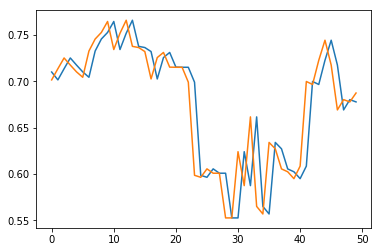

In [3]:
plt.plot(X_train[:50])
plt.plot(y_train[:50])

In [13]:
#Callback function for online plot while fitting

from IPython.display import clear_output


class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        n_step=20
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses)%n_step==0:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

In [14]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [15]:
# choose a number of time steps
n_steps = 24
# split into samples
X, y = split_sequence(S1[:1000], n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

#X
#y[0]

Xt, yt=split_sequence(S1[-100:], n_steps)
Xt = Xt.reshape((Xt.shape[0], Xt.shape[1], n_features))
#yt=S1[-100+1:]


# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features),return_sequences=True))
model.add(LSTM(units=50, activation='relu', return_sequences=True))
model.add(LSTM(units=50, activation='relu'))
model.add
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer=tf.train.AdamOptimizer())#, metrics=["acc"])
# fit model

In [19]:
model.fit(X, y, epochs=1000, batch_size=32, verbose=0,shuffle=False, callbacks=[plot_losses])#EarlyStopping(monitor='val_loss', patience=50)])
#model.fit(X, y, epochs=2000, verbose=0,shuffle=False,validation_split=0.2,callbacks=[plot_losses, EarlyStopping(monitor='val_loss', patience=100)])


KeyboardInterrupt: 

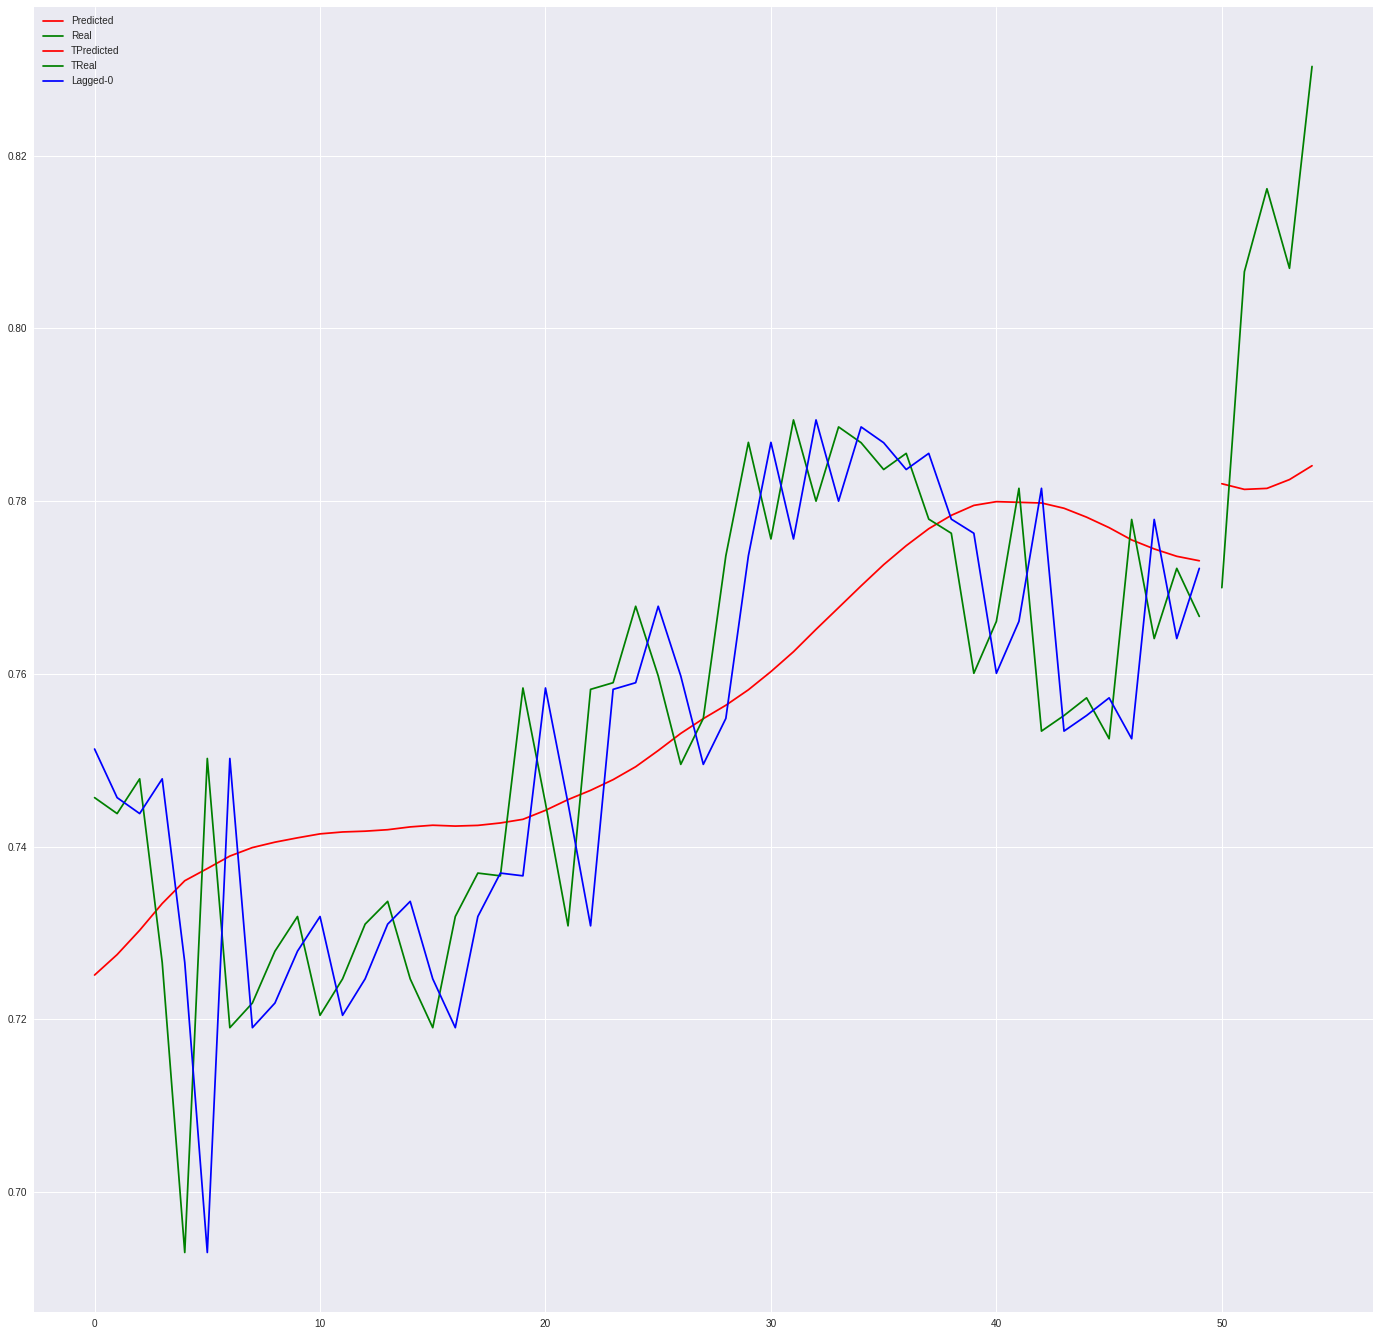

In [17]:
Xt, yt=split_sequence(S1[1000:1050], n_steps)

Xt = Xt.reshape((Xt.shape[0], Xt.shape[1], n_features))

ypt = model.predict(Xt[:5], verbose=0)
yrt = yt[:5]

yp = model.predict(X[50:100], verbose=0)
yr = y[50:100]


plt.figure(figsize=(24,24))
n=100
plt.plot(yp, color= 'red', label="Predicted")
plt.plot(yr, color='green', label="Real")

plt.plot(range(len(yp),len(yp)+len(ypt)),ypt,color="red", label="TPredicted")
plt.plot(range(len(yp),len(yp)+len(yrt)),yrt,color="green",  label="TReal")

plt.plot(X[50:100,n_steps-1], color='blue', label="Lagged-0")
#plt.plot(Xt[:5,n_steps-1], color='blue', label="Lagged-0")

plt.legend()
plt.show()

In [218]:
for i in range(10):
    print(Xt[i,23], yt[i], yhat[i])


[0.33648097] [0.28853552] [0.35829258]
[0.28853552] [0.23944196] [0.30902788]
[0.23944196] [0.32168729] [0.26010272]
[0.32168729] [0.35129762] [0.3340825]
[0.35129762] [0.23887543] [0.37259173]
[0.23887543] [0.22539468] [0.26606396]
[0.22539468] [0.22632966] [0.24398328]
[0.22632966] [0.21790811] [0.24568862]
[0.21790811] [0.2281814] [0.24088095]
[0.2281814] [0.23807118] [0.250365]


In [324]:
score, acc = model.evaluate(X[50:100], y[50:100],batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

50/50 [==============================] - 5s 98ms/step
Test score: 0.00605501833371818
Test accuracy: 0.0


In [72]:
save=True
model_name="lstm_models/LSTM_norm"
model_weights=model_name+"_weigths.h5"
    
if save:
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_name+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_weights)
    print("Saved model to disk")
    colab=False
    if colab:
        from google.colab import files
        files.download(model_name+".json")
        files.download(weigths_name)

# later...
load=False
if load:
    json_file = open(model_name+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weigths_name)
    print("Loaded model from disk")

recompile=False
if recompile:
    loaded_model.compile(loss='mae', optimizer=tf.train.AdamOptimizer())

Saved model to disk
